In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.set_option('display.max_rows', None)  # Отображение всех строк  
pd.set_option('display.max_columns', None)  # Отображение всех столбцов  

In [104]:
df = pd.read_csv('starts.csv')
df['event_date'] = pd.to_datetime(df['event_date'])
print(df.columns[20])
df.info()

rain.1h
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178857 entries, 0 to 178856
Data columns (total 23 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   record_id                  178857 non-null  int64         
 1   athlete_id                 178857 non-null  int64         
 2   event_name                 178857 non-null  object        
 3   event_date                 178857 non-null  datetime64[ns]
 4   city                       178857 non-null  object        
 5   region                     178857 non-null  object        
 6   finish_time                178857 non-null  int64         
 7   athlete_gender             178857 non-null  object        
 8   athlete_age                178857 non-null  int64         
 9   is_newbie                  178857 non-null  int64         
 10  temp                       178857 non-null  float64       
 11  feels_like                 178857 non-null  

In [116]:
print('Медианный возраст:', df.athlete_age.quantile(0.5))
print('Медианное кол-во людей в забеге:', df.groupby(['event_name', 'event_date']).agg(cnt_people=('athlete_id', 'nunique')).cnt_people.quantile(0.5))
print('Медианное кол-во пробежек на 1 пользователя:', df.groupby('athlete_id').agg(run_on_person=('athlete_id', 'count')).run_on_person.quantile(0.5))

Медианный возраст: 38.0
Медианное кол-во людей в забеге: 24.0
Медианное кол-во пробежек на 1 пользователя: 2.0


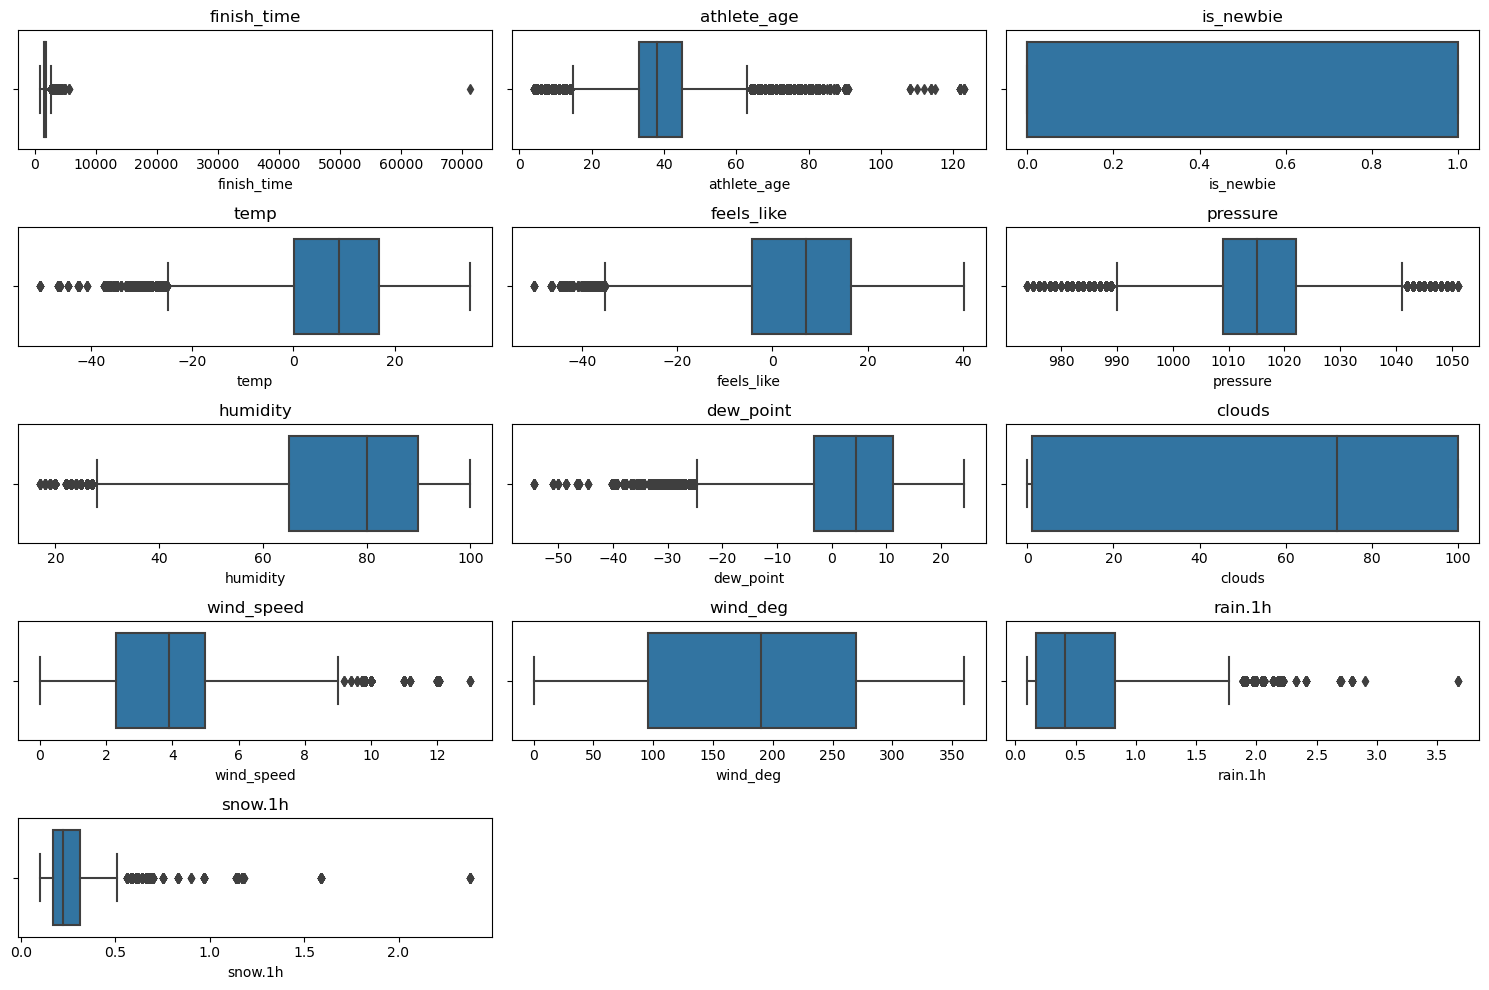

In [106]:
numerical_df = df.select_dtypes(exclude="object")
numerical_df = numerical_df.drop(columns=['record_id', 'athlete_id', 'event_date'])
plt.figure(figsize=(15, 10))  
for i, column in enumerate(numerical_df.columns):  
    plt.subplot(len(numerical_df.columns) // 3 + 1, 3, i + 1)  
    sns.boxplot(x=numerical_df[column])  
    plt.title(column)  

plt.tight_layout()  
plt.show()  

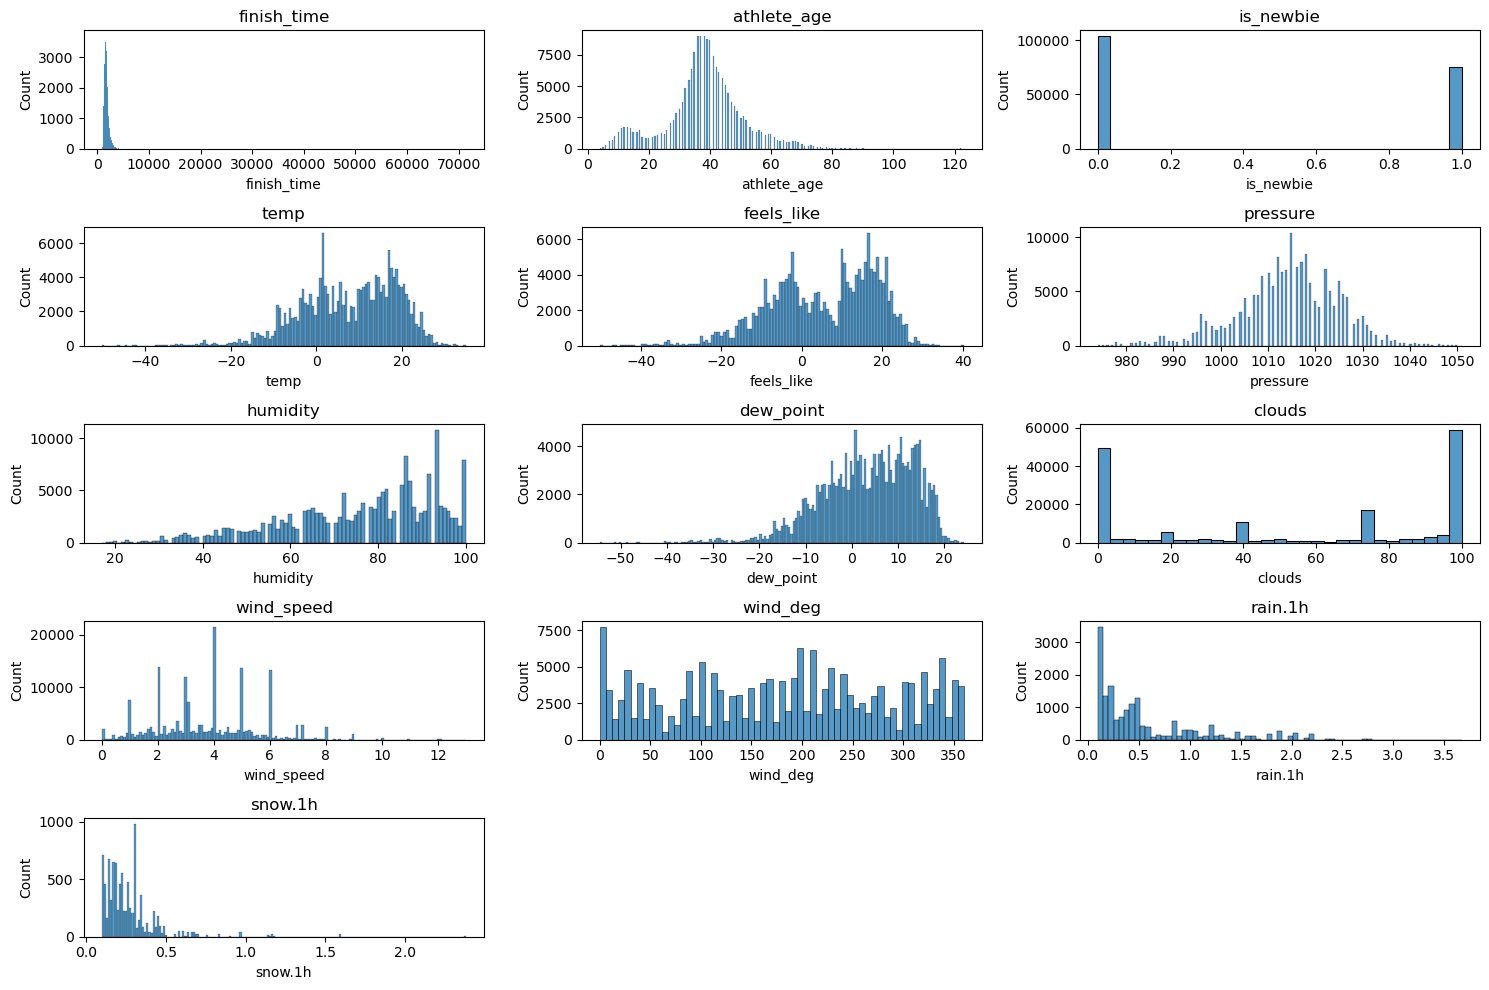

In [107]:
numerical_df = df.select_dtypes(exclude="object")
numerical_df = numerical_df.drop(columns=['record_id', 'athlete_id', 'event_date'])
plt.figure(figsize=(15, 10))  
for i, column in enumerate(numerical_df.columns):  
    plt.subplot(len(numerical_df.columns) // 3 + 1, 3, i + 1)  
    sns.histplot(x=numerical_df[column])  
    plt.title(column)  

plt.tight_layout()  
plt.show()  

In [80]:
outliers = pd.DataFrame(columns=['Переменная', 'Нижняя граница', 'Верхняя граница', 'IQR', 'Количество выбросов'])
for column in numerical_df.columns:
    q1 = numerical_df[column].quantile(0.25)  # 25-й процентиль
    q3 = numerical_df[column].quantile(0.75)  # 75-й процентиль
    iqr = q3 - q1
    outliers = pd.concat([outliers, pd.DataFrame([{'Переменная': column, 'Нижняя граница': q1 - 1.5 * iqr, 'Верхняя граница': q3 + 1.5 * iqr, 'IQR': iqr, 'Количество выбросов': df[(df[column] > q3 + 1.5 * iqr) | (df[column] < q1 - 1.5 * iqr)].shape[0]}])], ignore_index=True)
outliers

,Переменная,Нижняя граница,Верхняя граница,IQR,Количество выбросов
0,finish_time,741.500,2665.500,481.00,6484
1,athlete_age,15.000,63.000,12.00,16297
2,temp,-24.960,42.080,16.76,1419
3,feels_like,-35.155,47.445,20.65,595
4,pressure,989.500,1041.500,13.00,5287
5,humidity,27.500,127.500,25.00,920
6,dew_point,-24.960,33.040,14.50,1897
7,clouds,-147.500,248.500,99.00,0
8,wind_speed,-1.725,9.035,2.69,624
9,rain.1h,-0.820,1.820,0.66,959


Удалим всех людей, которые шли шагом или медленее (5 км/ч)

In [81]:
new_df = df[df['finish_time'] < 3600]

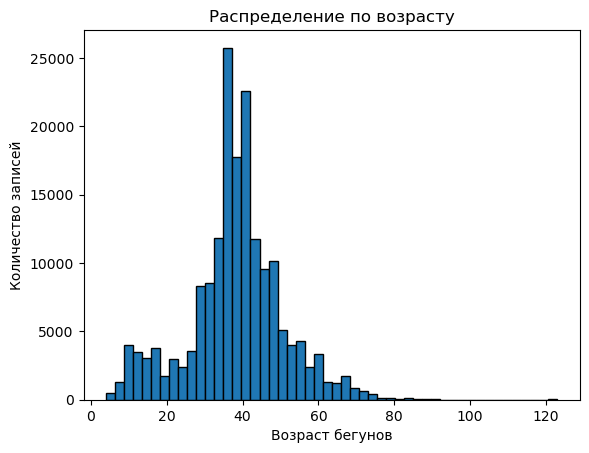

In [82]:
plt.hist(new_df['athlete_age'], bins=50, edgecolor='black')
plt.title('Распределение по возрасту')
plt.xlabel('Возраст бегунов')
plt.ylabel('Количество записей')
plt.show()

На распределении видно, что выбросами являются участники старше 80 лет

In [83]:
new_df = new_df[new_df['athlete_age'] < 80]

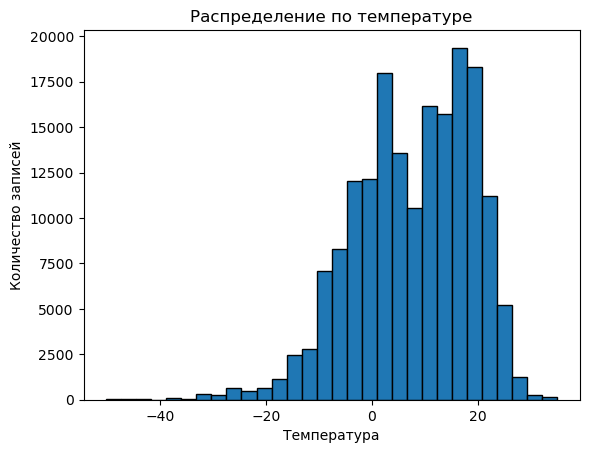

In [84]:
plt.hist(new_df['temp'], bins=30, edgecolor='black')
plt.title('Распределение по температуре')
plt.xlabel('Температура')
plt.ylabel('Количество записей')
plt.show()

In [85]:
low_temp_df = new_df[new_df['temp'] < -23]

In [86]:
low_temp_df.loc[:, 'month'] = low_temp_df['event_date'].dt.month

C:\Users\1\AppData\Local\Temp\ipykernel_16084\2967033106.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_temp_df.loc[:, 'month'] = low_temp_df['event_date'].dt.month


In [87]:
low_temp_df['month'].value_counts()

month
12    825
1     804
2     112
3       9
Name: count, dtype: int64

In [88]:
low_temp_df[low_temp_df['month'] == 3]

,record_id,athlete_id,event_name,event_date,city,region,finish_time,athlete_gender,athlete_age,is_newbie,temp,feels_like,pressure,humidity,dew_point,clouds,wind_speed,wind_deg,weather.main,weather.description,rain.1h,snow.1h,track_description_surface,month
31336,5975,790079611,Воркута Городской парк,2023-03-04,Воркута,Республика Коми,1826,женский,37,0,-27.17,-32.35,1002,79,-29.47,97,1.38,200,Clouds,overcast clouds,NaN,NaN,асфальт,3
63699,5975,790104282,Воркута Городской парк,2023-03-04,Воркута,Республика Коми,1490,мужской,56,0,-27.17,-32.35,1002,79,-29.47,97,1.38,200,Clouds,overcast clouds,NaN,NaN,асфальт,3
74357,5975,790110203,Воркута Городской парк,2023-03-04,Воркута,Республика Коми,1486,мужской,45,0,-27.17,-32.35,1002,79,-29.47,97,1.38,200,Clouds,overcast clouds,NaN,NaN,асфальт,3
74460,5975,790110215,Воркута Городской парк,2023-03-04,Воркута,Республика Коми,1689,мужской,43,0,-27.17,-32.35,1002,79,-29.47,97,1.38,200,Clouds,overcast clouds,NaN,NaN,асфальт,3
74533,5975,790110219,Воркута Городской парк,2023-03-04,Воркута,Республика Коми,1805,мужской,43,0,-27.17,-32.35,1002,79,-29.47,97,1.38,200,Clouds,overcast clouds,NaN,NaN,асфальт,3
83487,5975,790113808,Воркута Городской парк,2023-03-04,Воркута,Республика Коми,1715,мужской,36,0,-27.17,-32.35,1002,79,-29.47,97,1.38,200,Clouds,overcast clouds,NaN,NaN,асфальт,3
87402,5975,790115431,Воркута Городской парк,2023-03-04,Воркута,Республика Коми,1837,женский,47,0,-27.17,-32.35,1002,79,-29.47,97,1.38,200,Clouds,overcast clouds,NaN,NaN,асфальт,3
116802,5975,790127743,Воркута Городской парк,2023-03-04,Воркута,Республика Коми,1621,мужской,24,1,-27.17,-32.35,1002,79,-29.47,97,1.38,200,Clouds,overcast clouds,NaN,NaN,асфальт,3
119581,5975,790128597,Воркута Городской парк,2023-03-04,Воркута,Республика Коми,1480,мужской,35,1,-27.17,-32.35,1002,79,-29.47,97,1.38,200,Clouds,overcast clouds,NaN,NaN,асфальт,3


4-ого марта в Воркуте действительно была такая температура

In [89]:
super_low_temp_df = new_df[new_df['temp'] < -40]
super_low_temp_df['city'].unique()

array(['Якутск'], dtype=object)

В Якутске действительно очень холодно, поэтому в переменной temp нет выбросов. Тоже самое с переменной feels like

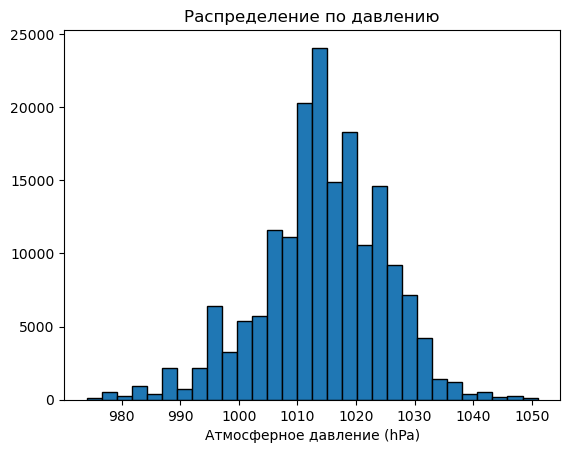

In [90]:
plt.hist(new_df['pressure'], bins=30, edgecolor='black')
plt.title('Распределение по давлению')
plt.xlabel('Атмосферное давление (hPa)')
plt.show()

В давлении нет выбросов

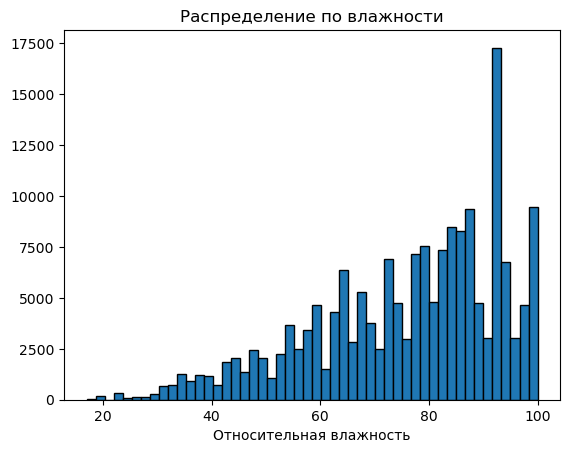

In [91]:
plt.hist(new_df['humidity'], bins=50, edgecolor='black')
plt.title('Распределение по влажности')
plt.xlabel('Относительная влажность')
plt.show()

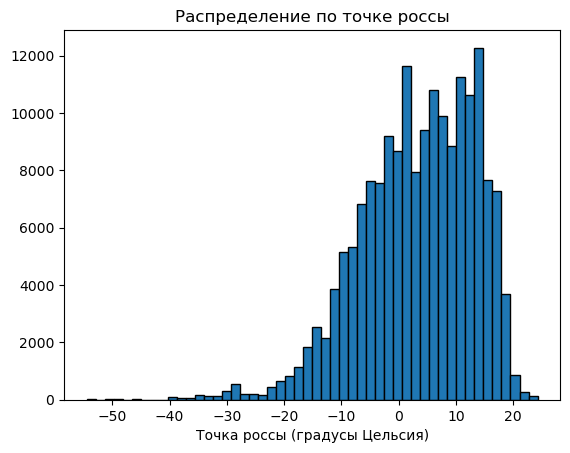

In [92]:
plt.hist(new_df['dew_point'], bins=50, edgecolor='black')
plt.title('Распределение по точке россы')
plt.xlabel('Точка россы (градусы Цельсия)')
plt.show()

In [93]:
new_df[new_df['dew_point'] < -40]['city'].value_counts()

city
Якутск         84
Новосибирск    17
Иркутск        16
Томск          15
Name: count, dtype: int64

In [94]:
super_low_point = new_df[new_df['dew_point'] < -40]
super_low_point.loc[:, 'month'] = super_low_point['event_date'].dt.month
super_low_point['month'].value_counts()

C:\Users\1\AppData\Local\Temp\ipykernel_16084\1467462739.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super_low_point.loc[:, 'month'] = super_low_point['event_date'].dt.month


month
12    74
1     52
2      6
Name: count, dtype: int64

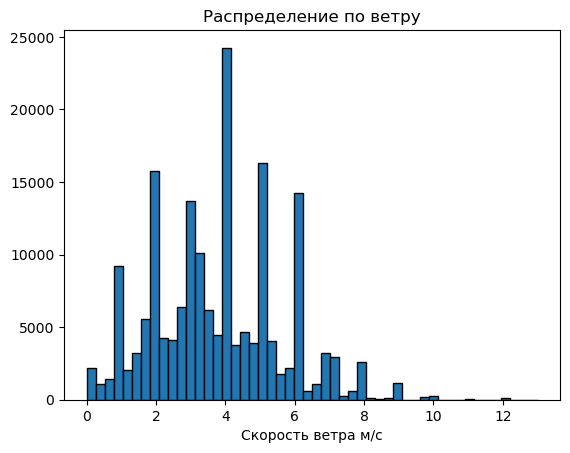

In [95]:
plt.hist(new_df['wind_speed'], bins=50, edgecolor='black')
plt.title('Распределение по ветру')
plt.xlabel('Скорость ветра м/с')
plt.show()

In [96]:
new_df['city'][new_df['wind_speed'] > 10].value_counts()

city
Екатеринбург    52
Томск           41
Челябинск       41
Кемерово        22
Омск            14
Калуга          12
Чебоксары       11
Орск            11
Железноводск     7
Name: count, dtype: int64

Вполне вероятно, что эти значенияя не выбросы, так как большинство этих городов являются ветреными

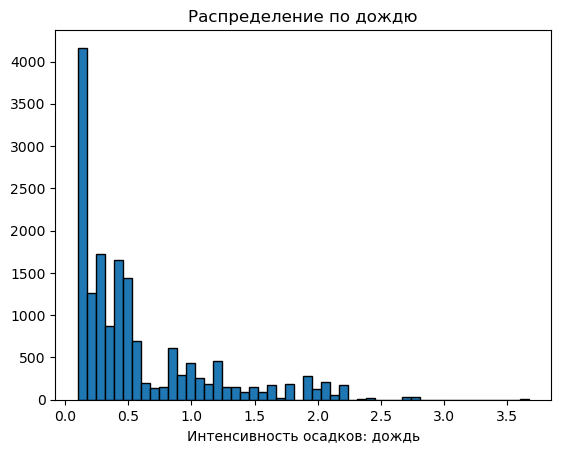

In [108]:
plt.hist(new_df['rain.1h'], bins=50, edgecolor='black')
plt.title('Распределение по дождю')
plt.xlabel('Интенсивность осадков: дождь')
plt.show()

Что-то очень странно, GPT говорит, что так распределяется:
Слабый дождь: до 2,5 мм/час.
Умеренный дождь: от 2,5 до 7,6 мм/час.
Сильный дождь: от 7,6 мм/час и выше.
Ливень: более 50 мм/час.

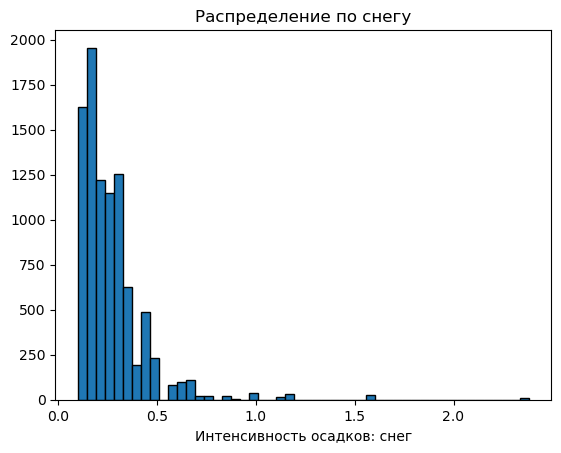

In [98]:
plt.hist(new_df['snow.1h'], bins=50, edgecolor='black')
plt.title('Распределение по снегу')
plt.xlabel('Интенсивность осадков: снег')
plt.show()

Выбросов нет

In [110]:
#ДАЛЕЕ МАКСИМ делает

new_df[new_df['snow.1h'] > 2.0]

,record_id,athlete_id,event_name,event_date,city,region,finish_time,athlete_gender,athlete_age,is_newbie,temp,feels_like,pressure,humidity,dew_point,clouds,wind_speed,wind_deg,weather.main,weather.description,rain.1h,snow.1h,track_description_surface
34394,11991,790081423,Орск парк Строителей,2023-10-28,Орск,Оренбургская область,1876,женский,63,0,0.61,-4.15,1008,99,0.47,100,5.0,130,Rain,light rain,NaN,2.38,грунт
34490,11991,790081527,Орск парк Строителей,2023-10-28,Орск,Оренбургская область,1422,мужской,46,0,0.61,-4.15,1008,99,0.47,100,5.0,130,Rain,light rain,NaN,2.38,грунт
34703,11991,790081745,Орск парк Строителей,2023-10-28,Орск,Оренбургская область,1492,мужской,37,0,0.61,-4.15,1008,99,0.47,100,5.0,130,Rain,light rain,NaN,2.38,грунт
36424,11991,790083775,Орск парк Строителей,2023-10-28,Орск,Оренбургская область,1553,мужской,41,0,0.61,-4.15,1008,99,0.47,100,5.0,130,Rain,light rain,NaN,2.38,грунт
45317,11991,790091739,Орск парк Строителей,2023-10-28,Орск,Оренбургская область,1460,мужской,32,0,0.61,-4.15,1008,99,0.47,100,5.0,130,Rain,light rain,NaN,2.38,грунт
77613,11991,790111187,Орск парк Строителей,2023-10-28,Орск,Оренбургская область,1653,мужской,54,0,0.61,-4.15,1008,99,0.47,100,5.0,130,Rain,light rain,NaN,2.38,грунт
107588,11991,790124655,Орск парк Строителей,2023-10-28,Орск,Оренбургская область,1875,мужской,52,1,0.61,-4.15,1008,99,0.47,100,5.0,130,Rain,light rain,NaN,2.38,грунт
163588,11991,790148503,Орск парк Строителей,2023-10-28,Орск,Оренбургская область,2572,женский,36,1,0.61,-4.15,1008,99,0.47,100,5.0,130,Rain,light rain,NaN,2.38,грунт
168843,11991,790151957,Орск парк Строителей,2023-10-28,Орск,Оренбургская область,2574,женский,46,1,0.61,-4.15,1008,99,0.47,100,5.0,130,Rain,light rain,NaN,2.38,грунт


РАССМОТРЕНИЕ МЕДИАННЫХ ЗНАЧЕНИЙ ДОБАВИЛ В НАЧАЛО БЛОКНОТА


In [120]:
newbie_by_region = new_df.drop_duplicates('athlete_id').groupby('region').agg(cnt_newbie = ('athlete_id', lambda x: len(x[new_df.is_newbie == 1])))
newbie_by_region.head(3)

,cnt_newbie
region,
Архангельская область,44
Астраханская область,117
Белгородская область,242
